# Bosch Connected Experience (BCX) 2020

## Implementation of Grow Clean Air under the concept of [City Tree](https://greencitysolutions.de/en/) in BCX20 by: 

$Mehryar{\,}Majd$       ${\,}{\,}{\,}{\,}{\,}{\,}{\,}$           __Gmail: mehryar.majd@gmail.com__

__17-18 Feb, 2020, Berlin__ 

In [7]:
![title1](CityTree.png)

'[title1]' is not recognized as an internal or external command,
operable program or batch file.


![title2](IM_CityTree.jpg)

In [ ]:
#!/usr/bin/env python 2. 
# -*- coding: utf-8 -*- 
__author__ = "Mehryar Majd" 
__copyright__ = ["Copyright 2020, Grow Clean Air "] 
__credits__ = ["Mehryar Majd","Bosch Connected Experience(BCX) 2020"] 
__license__ = "Hackathon" 
__version__ = "Python 3.6" 
__maintainer__ = "Mehryar Majd" 
__email__ = "mehryar.majd@gmail.com" 
__status__ = "Prototype" 

'''  Provides prediction of humidity, temperature, fan speed & dif pressure developments on eTree based on time series. 
       Preprocessing data phase: Sorting, clean data, identification and plotting missing data, detect outliers 
       Missing data analysis, missing data frequency visualization  --->  missingno module. 
       ****************************************************
       ML & DL models implementation phase using multiprocessing & multithreading: 
       Splitting data, Creating ANNs/DNNs models: LSTM. 
       Design, fit, compile models, train & test data, 
       
       **************************************************** 
       Implementing evaluation: Plot loss plots, Print results: MAE, MSE 
       
''' 

# Import and call the needed libraries

In [32]:
# Import and call the needed libraries
import pandas as pd
import numpy as np
import os
import csv

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation , BatchNormalization, GRU, Flatten
from keras.callbacks import EarlyStopping

import numpy
from numpy import array, hstack
from numpy.random import uniform

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_curve, mean_absolute_error
from sklearn import preprocessing, tree, linear_model
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn import ensemble
from sklearn import datasets

import seaborn as sns

import sys
import time
import datetime
from math import sqrt
import math
from itertools import cycle

from scipy.special import boxcox1p
from scipy import stats
from scipy import interp

from pandas import read_csv

from tabulate import tabulate


In [3]:
fn = 'D:/berlin_sensordata.json.gz'
print(os.path.isfile(fn))
df = pd.read_json(fn, lines=True, compression='gzip')

True


In [5]:
df.head()

,absoluteHumidity1,absoluteHumidity2,aggregated,air,airQualityIndexPollutants,currentActuatorConfig,differentialPressurePascal,fan1Rpm,fan2Rpm,humidity1,humidity2,id,moduleId,receivedTimestamp,state,temperature1,temperature2,treeId,weather
0,5.999457,5.963408,NaN,NaN,NaN,"{'minimumHumidity': 80, 'maximumHumidity': 85,...",0.2,840.0,840.0,43.0,43.0,1570439258000-ct_berlin_1-d6,d6,1570439258000,"{'areFansEnabled': True, 'isWateringEnabled': ...",16.4,16.3,ct_berlin_1,NaN
1,6.018530,6.018530,NaN,NaN,NaN,"{'minimumHumidity': 80, 'maximumHumidity': 85,...",1.3,840.0,480.0,45.0,45.0,1570439258000-ct_berlin_1-d3,d3,1570439258000,"{'areFansEnabled': False, 'isWateringEnabled':...",15.7,15.7,ct_berlin_1,NaN
2,5.895329,6.138979,NaN,NaN,NaN,"{'minimumHumidity': 80, 'maximumHumidity': 85,...",0.9,840.0,840.0,42.0,44.0,1570439258000-ct_berlin_1-d5,d5,1570439258000,"{'areFansEnabled': True, 'isWateringEnabled': ...",16.5,16.4,ct_berlin_1,NaN
3,5.849228,5.708862,NaN,NaN,NaN,"{'minimumHumidity': 80, 'maximumHumidity': 85,...",1.2,840.0,840.0,44.0,44.0,1570439258000-ct_berlin_1-d4,d4,1570439258000,"{'areFansEnabled': True, 'isWateringEnabled': ...",15.6,15.2,ct_berlin_1,NaN
4,10.757431,11.806965,NaN,NaN,NaN,"{'minimumHumidity': 80, 'maximumHumidity': 85,...",0.0,0.0,0.0,86.0,91.0,1570545523000-ct_berlin_1-d5,d5,1570545523000,"{'areFansEnabled': False, 'isWateringEnabled':...",14.6,15.2,ct_berlin_1,NaN


# Missing value ratio

In [4]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10) 

,Missing Ratio
airQualityIndexPollutants,86.942824
aggregated,76.857110
weather,50.717054
temperature2,27.230105
temperature1,27.230105
state,27.230105
humidity2,27.230105
humidity1,27.230105
fan2Rpm,27.230105
fan1Rpm,27.230105


# Delete some fileds

In [5]:
df=df.drop("airQualityIndexPollutants",axis=1)
df=df.drop("air",axis=1)
df=df.drop('aggregated'	,axis=1)
df=df.drop('weather'	,axis=1)

# Fill missing data by mean values in target features

In [6]:
df['receivedTimestamp'].fillna((df['receivedTimestamp'].mean()), inplace=True)
df['fan2Rpm'].fillna((df['fan2Rpm'].mean()), inplace=True)
df['fan1Rpm'].fillna((df['fan1Rpm'].mean()), inplace=True)
df['differentialPressurePascal'].fillna((df['differentialPressurePascal'].mean()), inplace=True)
df['absoluteHumidity2'].fillna((df['absoluteHumidity2'].mean()), inplace=True)
df['absoluteHumidity1'].fillna((df['absoluteHumidity1'].mean()), inplace=True)

df['humidity2'].fillna((df['humidity2'].mean()), inplace=True)
df['humidity1'].fillna((df['humidity1'].mean()), inplace=True)
df['temperature2'].fillna((df['temperature2'].mean()), inplace=True)
df['temperature1'].fillna((df['temperature1'].mean()), inplace=True)


In [7]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(11) 

,Missing Ratio
state,27.230105
currentActuatorConfig,27.230105
moduleId,24.574844


# Preparing the data & data split

In [8]:
df.keys()

Index(['absoluteHumidity1', 'absoluteHumidity2', 'currentActuatorConfig',
       'differentialPressurePascal', 'fan1Rpm', 'fan2Rpm', 'humidity1',
       'humidity2', 'id', 'moduleId', 'receivedTimestamp', 'state',
       'temperature1', 'temperature2', 'treeId'],
      dtype='object')

In [9]:
col=['receivedTimestamp', 'temperature1',
       'temperature2', 'humidity1', 'humidity2', 'absoluteHumidity1',
       'absoluteHumidity2', 'differentialPressurePascal', 'fan1Rpm', 'fan2Rpm']

col2=['temperature1','temperature2',  'absoluteHumidity1',
       'absoluteHumidity2', 'differentialPressurePascal','fan1Rpm', 'fan2Rpm']

probs = np.random.rand(len(df))
training_mask = probs < 0.8
test_mask = (probs >= 0.80)

x_train_feat=df[col][training_mask]
x_test_feat=df[col][test_mask]
y_train_feat=df[col2][training_mask]
y_test_feat =df[col2][test_mask]

sc = StandardScaler()
x_train_feat = sc.fit_transform(x_train_feat)
x_test_feat = sc.transform(x_test_feat)
y_train_feat = sc.fit_transform(y_train_feat)
y_test_feat = sc.transform(y_test_feat)

In [10]:
x_train_feat = x_train_feat.reshape((x_train_feat.shape[0], 1, 10))
x_test_feat = x_test_feat.reshape((x_test_feat.shape[0], 1, 10))

In [11]:
model = Sequential()
model.add(LSTM(15,return_sequences=True ,input_shape=(1, 10)))
model.add(LSTM(15,return_sequences=True,dropout=0.50 ))
model.add(LSTM(15,return_sequences=True,dropout=0.50 ))
model.add(LSTM(15,return_sequences=True,dropout=0.50 ))
model.add(Flatten())

model.add(Dense(units = 20))
model.add(Activation('tanh'))
model.add(Dropout(0.50))
model.add(Dense(7))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 15)             1560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 15)             1860      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 15)             1860      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 15)             1860      
_________________________________________________________________
flatten_1 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                320       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
__________

In [ ]:
model.compile(loss="mse", optimizer="adam")

In [ ]:
model.summary()

In [12]:
hist_text=model.fit([x_train_feat], 
                    y_train_feat,
                    epochs=100,
                    batch_size=16,
                    validation_data=([x_test_feat],y_test_feat))

Train on 556346 samples, validate on 140045 samples
Epoch 1/100
556346/556346 [==============================] - 17s 31us/step - loss: 0.5680 - val_loss: 0.1869
Epoch 2/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2997 - val_loss: 0.1578
Epoch 3/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2735 - val_loss: 0.1443
Epoch 4/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2597 - val_loss: 0.1350
Epoch 5/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2505 - val_loss: 0.1302
Epoch 6/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2442 - val_loss: 0.1257
Epoch 7/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2397 - val_loss: 0.1226
Epoch 8/100
556346/556346 [==============================] - 11s 20us/step - loss: 0.2353 - val_loss: 0.1201
Epoch 9/100
556346/556346 [==============================] - 11s 20us/step -

In [13]:
#x_test_feat ],y_test_feat
ypred = model.predict(x_test_feat)
print("y1 MSE:%.4f" % mean_squared_error(y_test_feat[:,0], ypred[:,0]))
print("y2 MSE:%.4f" % mean_squared_error(y_test_feat[:,1], ypred[:,1]))
print("y3 MSE:%.4f" % mean_squared_error(y_test_feat[:,2], ypred[:,2]))
print("y4 MSE:%.4f" % mean_squared_error(y_test_feat[:,3], ypred[:,3]))
print("y5 MSE:%.4f" % mean_squared_error(y_test_feat[:,4], ypred[:,4]))
print("y6 MSE:%.4f" % mean_squared_error(y_test_feat[:,5], ypred[:,5]))
print("y7 MSE:%.4f" % mean_squared_error(y_test_feat[:,6], ypred[:,6]))


y1 MSE:0.1225
y2 MSE:0.1135
y3 MSE:0.1235
y4 MSE:0.1027
y5 MSE:0.0776
y6 MSE:0.0382
y7 MSE:0.0428


In [26]:
def mean_absolute_percentage_error(y_true, y_pred):     
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [33]:
#x_test_feat ],y_test_feat
ypred = model.predict(x_test_feat)
headers = []
headers.append("Error Measurement")
for i in range(7):
    headers.append("y" + str(i))

table = []

table.append([])
table[-1].append("MSE")
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,0], ypred[:,0]))
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,1], ypred[:,1]))
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,2], ypred[:,2]))
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,3], ypred[:,3]))
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,4], ypred[:,4]))
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,5], ypred[:,5]))
table[-1].append("%.4f" % mean_squared_error(y_test_feat[:,6], ypred[:,6]))

table.append([])
table[-1].append("MAE")
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,0], ypred[:,0]))
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,1], ypred[:,1]))
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,2], ypred[:,2]))
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,3], ypred[:,3]))
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,4], ypred[:,4]))
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,5], ypred[:,5]))
table[-1].append("%.4f" % mean_absolute_error(y_test_feat[:,6], ypred[:,6]))

# table.append([])
# table[-1].append("MAPE")
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,0], ypred[:,0]))
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,1], ypred[:,1]))
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,2], ypred[:,2]))
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,3], ypred[:,3]))
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,4], ypred[:,4]))
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,5], ypred[:,5]))
# table[-1].append("%.4f" % mean_absolute_percentage_error(y_test_feat[:,6], ypred[:,6]))

print(tabulate(table, headers=headers))

Error Measurement        y0      y1      y2      y3      y4      y5      y6
-------------------  ------  ------  ------  ------  ------  ------  ------
MSE                  0.1225  0.1135  0.1235  0.1027  0.0776  0.0382  0.0428
MAE                  0.2057  0.2003  0.2149  0.198   0.1578  0.1312  0.1388


# Prediction of temperature1

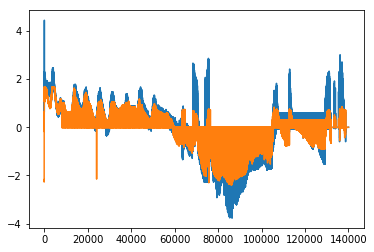

In [14]:
plt.plot(y_test_feat[:,0])
plt.plot(ypred[:,0])


# Prediction of temperature2

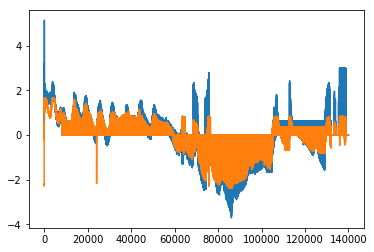

In [15]:
plt.plot(y_test_feat[:,1])
plt.plot(ypred[:,1])


# Prediction of absoluteHumidity1

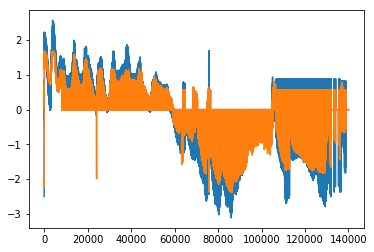

In [16]:
plt.plot(y_test_feat[:,2])
plt.plot(ypred[:,2])

# Prediction of absoluteHumidity2

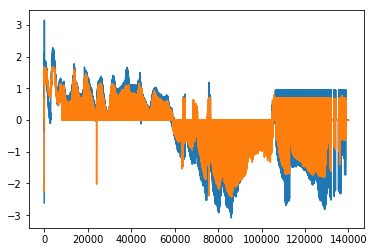

In [17]:
plt.plot(y_test_feat[:,3])
plt.plot(ypred[:,3])


# Prediction of differentialPressurePascal

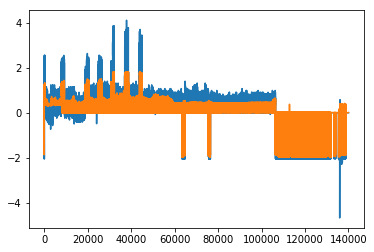

In [18]:
plt.plot(y_test_feat[:,4])
plt.plot(ypred[:,4])


# Prediction of fan1Rpm

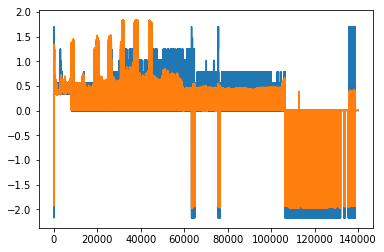

In [19]:
plt.plot(y_test_feat[:,5])
plt.plot(ypred[:,5])


# Prediction of fan2Rpm

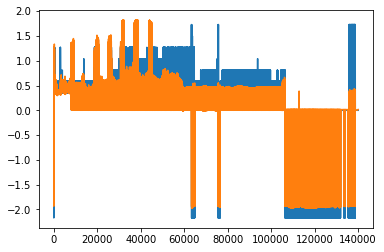

In [20]:
plt.plot(y_test_feat[:,6])
plt.plot(ypred[:,6])


# Performance of loss plot on train & test

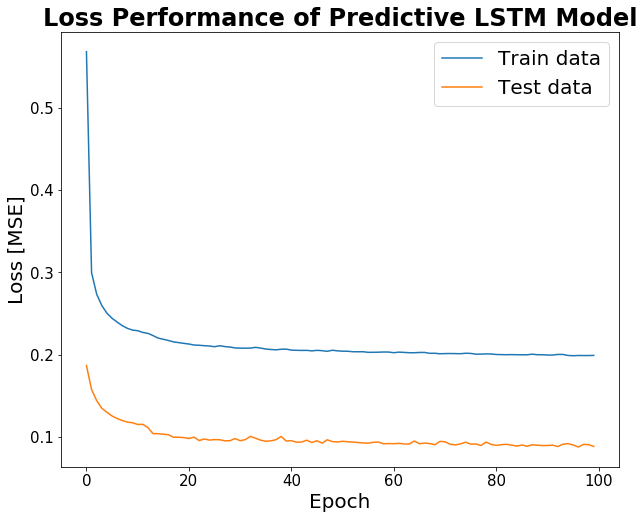

In [56]:
plt.figure(figsize=(10,8))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss Performance of Predictive LSTM Model', fontsize=24 ,fontweight='bold')
plt.ylabel('Loss [MSE]', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.legend(['Train data', 'Test data'], fontsize=20)
plt.show()

In [ ]:
np.savetxt("D:\\berlin_sensordata.csv", ypred, delimiter=",")

In [ ]:
dff=pd.(ypred())
dff.to_csv('D:\\berlin_sensordata_.csv', sep=',', header=None, index=None)